# Imports

In [30]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar
import xesmf as xe
from tqdm import tqdm
import gsw as gsw
import scipy as sci

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

print("numpy version =", np.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("xesmf version =", xe.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)
os.getcwd()

ProgressBar().register()

python version = 3.10.
numpy version = 1.26.4
scipy version = 1.14.0
xarray version = 2024.3.0
dask version = 2023.3.0
pandas version = 2.2.2
xesmf version = 0.8.7
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


# load data

In [31]:
print("Loading U experiment data")
u = xr.open_dataset("JRA55_pic_1m_grid_U_1958-2022.nc")['uo']
u_SEpac = xr.open_dataset("JRA55_SEPac_5d_grid_U_Y2022.nc")['uo']
u_SWpac = xr.open_dataset("JRA55_SWPac_5d_grid_U_Y2022.nc")['uo']
u_SEind = xr.open_dataset("JRA55_SEInd_5d_grid_U_Y2022.nc")['uo']
u_SWind = xr.open_dataset("JRA55_SWInd_5d_grid_U_Y2022.nc")['uo']

uthick = xr.open_dataset("JRA55_pic_1m_grid_U_1958-2022.nc")['e3u']
u_zonal_m = xr.open_dataset("ORCA2_xyz_grid_U.nc")['e1u']
u_merid_m = xr.open_dataset("ORCA2_xyz_grid_U.nc")['e2u']

print("Loading V experiment data")
v = xr.open_dataset("JRA55_pic_1m_grid_V_1958-2022.nc")['vo']
vthick = xr.open_dataset("JRA55_pic_1m_grid_V_1958-2022.nc")['e3v']
v_zonal_m = xr.open_dataset("ORCA2_xyz_grid_V.nc")['e1v']
v_merid_m = xr.open_dataset("ORCA2_xyz_grid_V.nc")['e2v']


# rename time dimension to year
u = u.rename({"time_counter":"month", "record":"year"})
v = v.rename({"time_counter":"month", "record":"year"})
uthick = uthick.rename({"time_counter":"month", "record":"year"})
vthick = vthick.rename({"time_counter":"month", "record":"year"})


Loading U experiment data
Loading V experiment data


# Annual mean of the U and V 

In [32]:
print("   Annual mean of U and V")
u = u.mean(dim='month')
v = v.mean(dim='month')

u_SEpac = u_SEpac.mean(dim='time_counter')
u_SWpac = u_SWpac.mean(dim='time_counter')

u_SEind = u_SEind.mean(dim='time_counter')
u_SWind = u_SWind.mean(dim='time_counter')

print("   Annual mean of U and V cell thicknesses")
uthick = uthick.mean(dim='month')
vthick = vthick.mean(dim='month')


   Annual mean of U and V
   Annual mean of U and V cell thicknesses


# Calculate average U and V though water column

In [33]:
print("   Water column integral of U velocity")
u = (u*uthick).sum(dim='depthu')# / uthick.sum(dim='depthu') 
u_SEpac = (u_SEpac*uthick.isel(year=0)).sum(dim='depthu')# / uthick.sum(dim='depthu') 
u_SWpac = (u_SWpac*uthick.isel(year=0)).sum(dim='depthu')# / uthick.sum(dim='depthu') 
u_SEind = (u_SEind*uthick.isel(year=0)).sum(dim='depthu')# / uthick.sum(dim='depthu') 
u_SWind = (u_SWind*uthick.isel(year=0)).sum(dim='depthu')# / uthick.sum(dim='depthu') 
print("   Water column integral of V velocity")
v = (v*vthick).sum(dim='depthv')# / vthick.sum(dim='depthv') 


   Water column integral of U velocity
   Water column integral of V velocity


# Calculate the barotropic streamfunction

In [34]:
u_psi = np.zeros_like(u)
u_SEpac_psi = np.zeros_like(u_SEpac)
u_SWpac_psi = np.zeros_like(u_SWpac)
u_SEind_psi = np.zeros_like(u_SEind)
u_SWind_psi = np.zeros_like(u_SWind)

print("  Integrate the U velocity in y space")
for ii in np.arange(len(u[0,0,:])):
    u_psi[:,::-1,ii] = (u[:,::-1,ii] * u_merid_m[::-1,ii]).cumsum(dim='y')
    u_SEpac_psi[::-1,ii] = (u_SEpac[::-1,ii] * u_merid_m[::-1,ii]).cumsum(dim='y')
    u_SWpac_psi[::-1,ii] = (u_SWpac[::-1,ii] * u_merid_m[::-1,ii]).cumsum(dim='y')
    u_SEind_psi[::-1,ii] = (u_SEind[::-1,ii] * u_merid_m[::-1,ii]).cumsum(dim='y')
    u_SWind_psi[::-1,ii] = (u_SWind[::-1,ii] * u_merid_m[::-1,ii]).cumsum(dim='y')


  Integrate the U velocity in y space


# Regrid the data

In [35]:
### create the rectilinear grid
ds_out = xe.util.grid_global(1,1)
print(ds_out)

# regrid the curvilinear --> rectilinear
regridder = xe.Regridder(u, ds_out, 'bilinear', ignore_degenerate=True)

print("  Regridding U streamfunction")
u_psi_reg = regridder(u_psi)
u_SEpac_psi_reg = regridder(u_SEpac_psi)
u_SWpac_psi_reg = regridder(u_SWpac_psi)
u_SEind_psi_reg = regridder(u_SEind_psi)
u_SWind_psi_reg = regridder(u_SWind_psi)
#print("  Regridding V streamfunction")
#v_psi_reg = regridder(v_psi)


<xarray.Dataset> Size: 2MB
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 518kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 518kB -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 523kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) float64 523kB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*
  Regridding U streamfunction


# Wrap coordinates

In [36]:
lon_reg = ds_out.coords['lon'].isel(y=0).values
lat_reg = ds_out.coords['lat'].isel(x=0).values

lon_reg = np.concatenate((lon_reg[-1, np.newaxis]-360, lon_reg))
u_psi_reg = np.concatenate((u_psi_reg[:,:,-1, np.newaxis], u_psi_reg[:,:,:]), axis=2)
u_SEpac_psi_reg = np.concatenate((u_SEpac_psi_reg[:,-1, np.newaxis], u_SEpac_psi_reg[:,:]), axis=1)
u_SWpac_psi_reg = np.concatenate((u_SWpac_psi_reg[:,-1, np.newaxis], u_SWpac_psi_reg[:,:]), axis=1)
u_SEind_psi_reg = np.concatenate((u_SEind_psi_reg[:,-1, np.newaxis], u_SEind_psi_reg[:,:]), axis=1)
u_SWind_psi_reg = np.concatenate((u_SWind_psi_reg[:,-1, np.newaxis], u_SWind_psi_reg[:,:]), axis=1)


# Plot the streamfunction

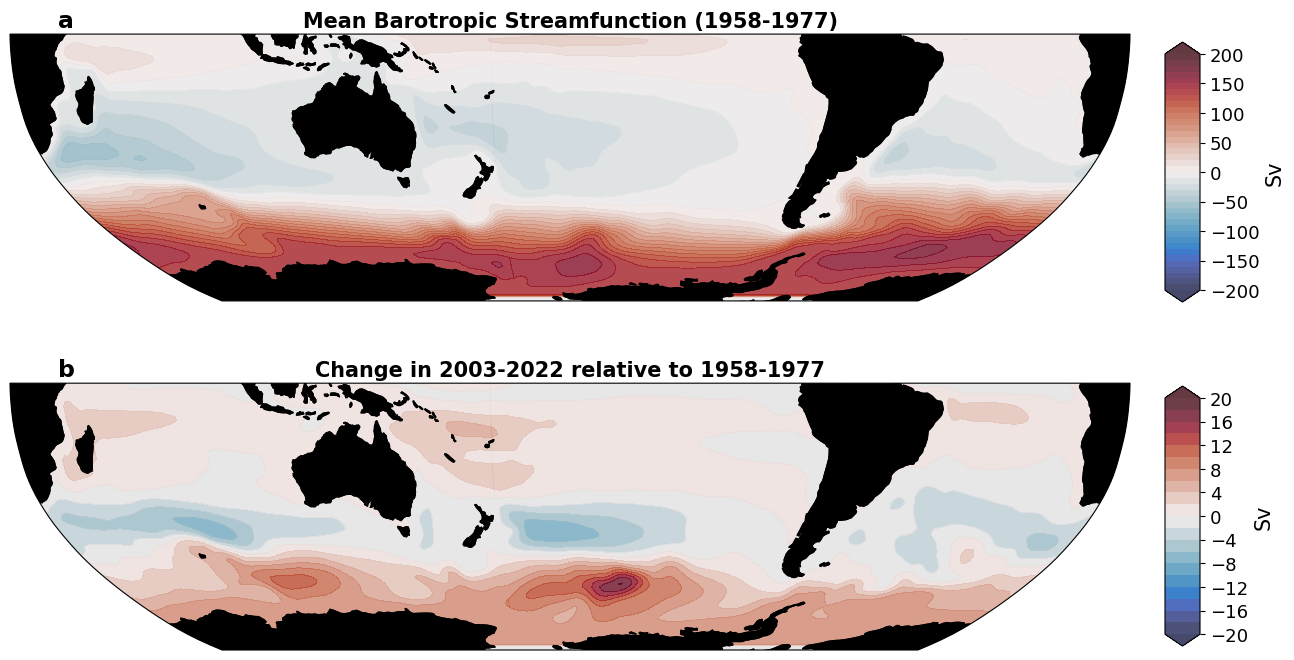

In [37]:

# set plotting values
proj = ccrs.Robinson(central_longitude=205)
levs1 = np.arange(-200,201,10)
colmap1 = lighten(cmo.balance, 0.8)
levs2 = np.arange(-20,21,2)
colmap2 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(14,8), facecolor='w')
gs = GridSpec(2,1)

# create axes
ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

# plot data
p1 = ax1.contourf(lon_reg, lat_reg, np.mean(u_psi_reg[0:20,:,:], axis=0)*1e-6, \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both', transform=ccrs.PlateCarree())
p2 = ax2.contourf(lon_reg, lat_reg, (np.mean(u_psi_reg[-20::,:,:], axis=0) - np.mean(u_psi_reg[0:20,:,:], axis=0))*1e-6, \
                  levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both', transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, zorder=3, color='k')
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3, color='k')
ax2.add_feature(cfeature.COASTLINE, zorder=3)

ax1.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())

xx = 0.5; yy = 1.05
plt.text(xx,yy,'Mean Barotropic Streamfunction (1958-1977)', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'Change in 2003-2022 relative to 1958-1977', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

plt.subplots_adjust(left=0.05, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.55,0.025,0.325])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar1.ax.set_ylabel("Sv", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

cbax2 = fig.add_axes([0.875,0.12,0.025,0.325])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::2])
cbar2.ax.set_ylabel("Sv", fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)


# Save figure

In [102]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-barotropic_streamfunction.png", dpi=300)
fig.savefig("fig-barotropic_streamfunction_transparent.png", dpi=300, transparent=True)


# Plot the streamfunction difference for the SEpac and SWpac experiments

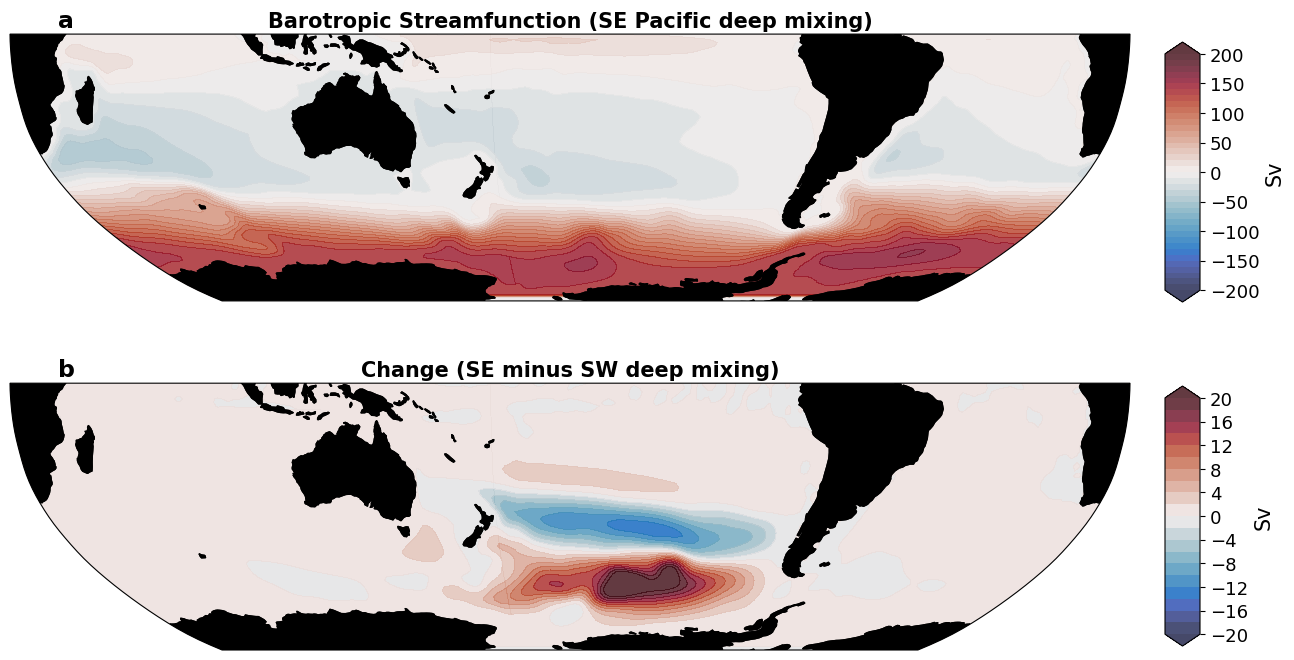

In [38]:
# set plotting values
proj = ccrs.Robinson(central_longitude=205)
levs1 = np.arange(-200,201,10)
colmap1 = lighten(cmo.balance, 0.8)
levs2 = np.arange(-20,21,2)
colmap2 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(14,8), facecolor='w')
gs = GridSpec(2,1)

# create axes
ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

# plot data
p1 = ax1.contourf(lon_reg, lat_reg, u_SEpac_psi_reg*1e-6, \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both', transform=ccrs.PlateCarree())
p2 = ax2.contourf(lon_reg, lat_reg, (u_SEpac_psi_reg - u_SWpac_psi_reg)*1e-6, \
                  levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both', transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, zorder=3, color='k')
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3, color='k')
ax2.add_feature(cfeature.COASTLINE, zorder=3)

ax1.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())

xx = 0.5; yy = 1.05
plt.text(xx,yy,'Barotropic Streamfunction (SE Pacific deep mixing)', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'Change (SE minus SW deep mixing)', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

plt.subplots_adjust(left=0.05, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.55,0.025,0.325])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar1.ax.set_ylabel("Sv", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

cbax2 = fig.add_axes([0.875,0.12,0.025,0.325])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::2])
cbar2.ax.set_ylabel("Sv", fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)


# Save

In [29]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-barotropic_streamfunction_SEvSW_Pacific.png", dpi=300)
fig.savefig("fig-barotropic_streamfunction_SEvSW_Pacific_transparent.png", dpi=300, transparent=True)


# SW and SE Indian experiments

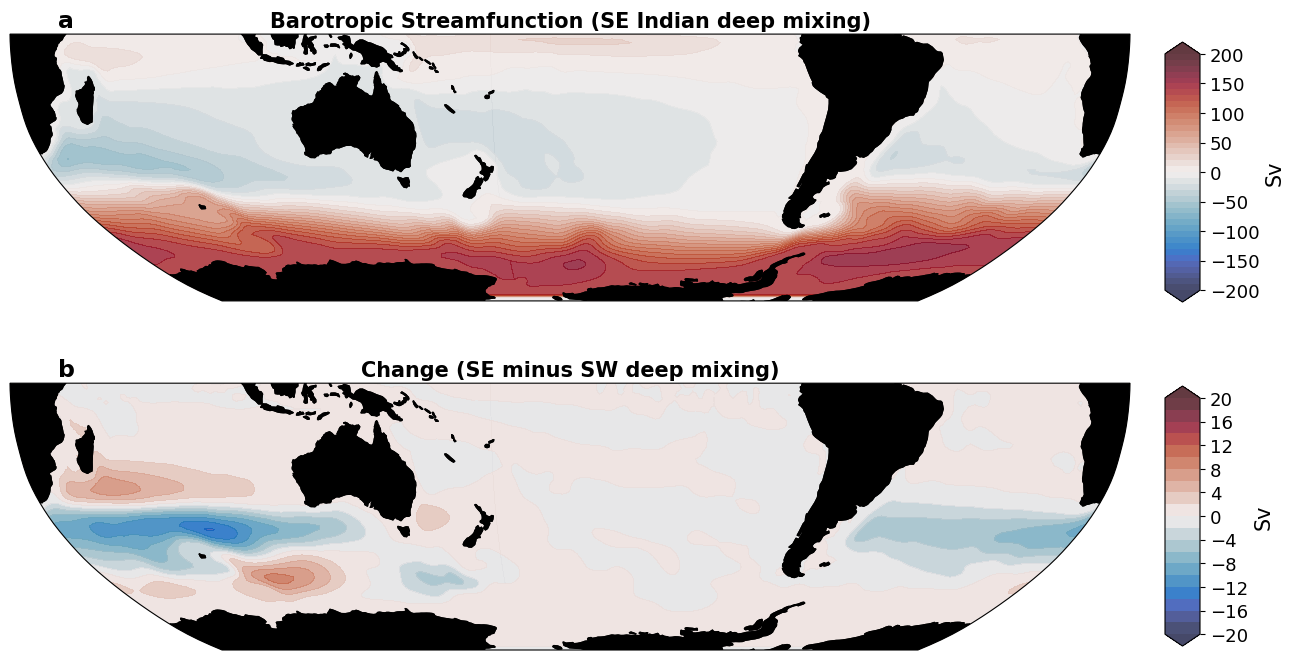

In [39]:
# set plotting values
proj = ccrs.Robinson(central_longitude=205)
levs1 = np.arange(-200,201,10)
colmap1 = lighten(cmo.balance, 0.8)
levs2 = np.arange(-20,21,2)
colmap2 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(14,8), facecolor='w')
gs = GridSpec(2,1)

# create axes
ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

# plot data
p1 = ax1.contourf(lon_reg, lat_reg, u_SEind_psi_reg*1e-6, \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both', transform=ccrs.PlateCarree())
p2 = ax2.contourf(lon_reg, lat_reg, (u_SEind_psi_reg - u_SWind_psi_reg)*1e-6, \
                  levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both', transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, zorder=3, color='k')
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3, color='k')
ax2.add_feature(cfeature.COASTLINE, zorder=3)

ax1.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,-80,0], crs=ccrs.PlateCarree())

xx = 0.5; yy = 1.05
plt.text(xx,yy,'Barotropic Streamfunction (SE Indian deep mixing)', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'Change (SE minus SW deep mixing)', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

plt.subplots_adjust(left=0.05, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.55,0.025,0.325])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar1.ax.set_ylabel("Sv", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

cbax2 = fig.add_axes([0.875,0.12,0.025,0.325])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::2])
cbar2.ax.set_ylabel("Sv", fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)


# Save

In [40]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-barotropic_streamfunction_SEvSW_Indian.png", dpi=300)
fig.savefig("fig-barotropic_streamfunction_SEvSW_Indian_transparent.png", dpi=300, transparent=True)
